In [1]:
# packages

# JAX
import jax.ops as jop
import jax.numpy as jnp
from jax import grad, vmap
#from jax.config import config; 
import jax
jax.config.update("jax_enable_x64", True)

# Numpy
import numpy as onp
from numpy import random 

# Plot
import matplotlib.pyplot as plt


We solve the following Burgers equation 

## General equation

\begin{equation*}
\begin{aligned}
& \partial_t (\phi S_p) + \nabla \cdot (K(x) \nabla \Phi_p ) = f, x \in [-1,1], t \in [0,1]\\
& \nabla \Phi_p(x,t) = \nabla p_p - \rho_p g \\
& f(\{S_p\}_{p=\{o,w,g\}})=0 \\
& u(0,x)=-\sin(\pi x)\\
& u(t,-1)=u(t,1)=0
\end{aligned}
\end{equation*}




## 1D time derivative equation

\begin{equation*}
\begin{aligned}
& \partial_t (\phi S) + \partial_x (K_x(x) \partial_x \Phi_p) = f , x \in [-1,1], t \in [0,1]\\

& \nabla \Phi_p(x,t) = \nabla p_p - \rho_p g \\
& f(\{S_p\}_{p=\{o,w,g\}})=0 \\

& u(0,x)=-\sin(\pi x)\\
& u(t,-1)=u(t,1)=0
\end{aligned}
\end{equation*}

The parameter $\nu$ controls the shock.

## 1D time derivative equation 1 Phase

\begin{equation*}
\begin{aligned}
& \partial_t p + \partial_x (K_x(x) \partial_x \Phi_p) = f , x \in [-1,1], t \in [0,1]\\


& \nabla \Phi_p(x,t) = \nabla p_p - \rho_p g \\
& S = \frac{p}{\phi} \\
& f(\{S_p\}_{p=\{o,w,g\}})=0 \\

& \partial_t p + \partial_x (K_x(x) \partial_x p) = f , x \in [-1,1], t \in [0,1]\\

& u(0,x)=-\sin(\pi x)\\
& u(t,-1)=u(t,1)=0
\end{aligned}
\end{equation*}

The parameter $\nu$ controls the shock.

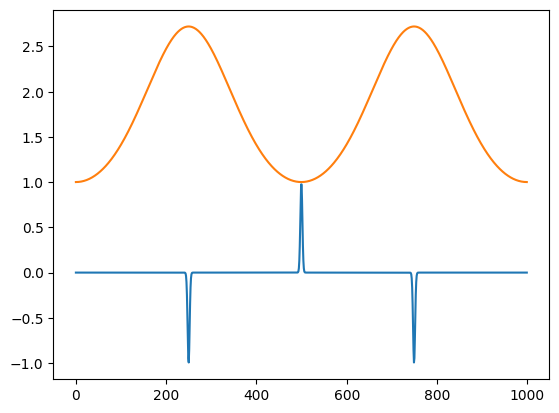

In [37]:
# fix random seeds, for generating reference solution & sampled points
# random.seed(20)

# we will use x=(x1,x2) as (t,x)

alpha = 1 # control the nonlinearity
# nu = 0.03/onp.pi # control the diffusion, nu = 0.01/pi leads to strong shock
nu = 0.02

well_pos=[0.5]
inje_pos=[0.25,0.75]
# boundary condition

def K(x1):
    return jnp.exp(1.0*(jnp.sin(x1*2*jnp.pi)**2)+1e-3)
    #return 0.5

def u(x1,w_p,i_p,amp=1e-5,x2=None):
    w_pot = jnp.sum(jnp.exp((-(x1-onp.expand_dims(onp.array(w_p),axis=1))**2)/amp),axis=0)
    i_pot = jnp.sum(jnp.exp((-(x1-onp.expand_dims(onp.array(i_p),axis=1))**2)/amp),axis=0)
    return w_pot - i_pot + 0*(x1==0)

plt.plot(u(x1=onp.linspace(0,1,1000),w_p=well_pos,i_p=inje_pos))
plt.plot(K(x1=onp.linspace(0,1,1000)))

# right hand side
def f(x1, x2):
    return 0


\begin{equation*}
\begin{aligned}
R_i=((p)_i^{n+1}-(p)_i^{n}) + (K_x)_{i-\frac{1}{2}}^n \ (1 - kg) \frac{\Delta t^n}{h}((p)_{i}^{n}-(p)_{i-1}^{n})-(K_x)_{i+\frac{1}{2}}^n \ (1 - kg) \frac{\Delta t^n}{h}((p)_{i+1}^{n}-(p)_i^{n}) - \Delta t^n f \\ h, x \in [-1,1], t \in [0,1]\\
\end{aligned}
\end{equation*}

$$
\begin{equation*}
\begin{aligned}
D_{thk}=(1 - kg) \frac{\Delta t^n}{h}
\end{aligned}
\end{equation*}
$$

\begin{equation*}
\begin{aligned}
R_i=((p)_i^{n+1}-(p)_i^{n})  + (K_x)_{i-\frac{1}{2}}^n D_{thk}((p)_{i}^{n}-(p)_{i-1}^{n})-(K_x)_{i+\frac{1}{2}}^n \ D_{thk}((p)_{i+1}^{n}-(p)_i^{n}) - \Delta t^n f \\ h, x \in [-1,1], t \in [0,1]\\
\end{aligned}
\end{equation*}

\begin{equation*}
\begin{aligned}
J_{i,i}=\partial_{p_i} R_i= 1 + (K_x)_{i-\frac{1}{2}}^n D_{thk}+(K_x)_{i+\frac{1}{2}}^n D_{thk} \\ h, x \in [-1,1], t \in [0,1]\\
\end{aligned}
\end{equation*}

\begin{equation*}
\begin{aligned}
J_{i,i+1}=\partial_{p_{i+1}} R_i=-(K_x)_{i+\frac{1}{2}}^n \ D_{thk}(p)_{i+1}^{n}
\\ h, x \in [-1,1], t \in [0,1]\\
\end{aligned}
\end{equation*}

\begin{equation*}
\begin{aligned}
J_{i,i-1}=\partial_{p_{i-1}} R_i= -(K_x)_{i-\frac{1}{2}}^n D_{thk}(p)_{i-1}^{n} \\ h, x \in [-1,1], t \in [0,1]\\
\end{aligned}
\end{equation*}


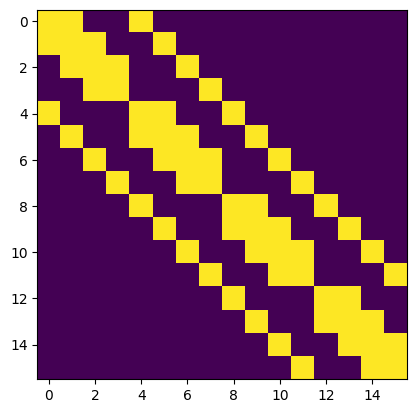

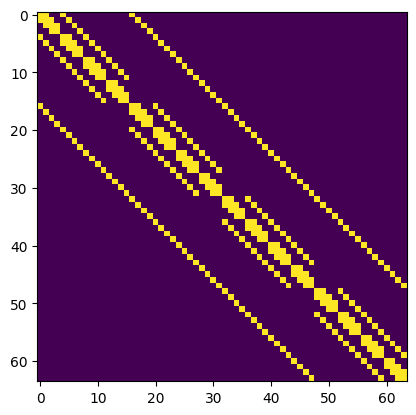

In [608]:
def get_neig(T,row, col):
    #row, col = 1, 1


    # Get immediate neighbors (up, down, left, right)
    # Check for boundary conditions to avoid index errors
    neighbors = []
    neighbors.append(T[row, col])
    if row > 0: # Up
        neighbors.append(T[row - 1, col])
    if row < T.shape[0] - 1: # Down
        neighbors.append(T[row + 1, col])
    if col > 0: # Left
        neighbors.append(T[row, col - 1])
    if col < T.shape[1] - 1: # Right
        neighbors.append(T[row, col + 1])
    return onp.array(neighbors)

def get_neig_3D(T,row, col, h):
    neighbors = []
    neighbors.append(T[row, col, h])
    if row > 0: # Up
        neighbors.append(T[row - 1, col,h])
    if row < T.shape[0] - 1: # Down
        neighbors.append(T[row + 1, col,h])
    if col > 0: # Left
        neighbors.append(T[row, col - 1,h])
    if col < T.shape[1] - 1: # Right
        neighbors.append(T[row, col + 1,h])
    if h > 0: # Left
        neighbors.append(T[row, col,h - 1])
    if h < T.shape[2] - 1: # Right
        neighbors.append(T[row, col,h + 1])
    return onp.array(neighbors)

size=4

T=onp.arange(size*size).reshape(size,size)
adjs=list(map(lambda ij:get_neig(T,*ij[::-1]),
         onp.stack(onp.meshgrid(onp.arange(size),onp.arange(size)),axis=-1).reshape(-1,2)
         ))

M=onp.zeros((size**2,size**2))
for adj,mc in zip(adjs,M):
    mc[adj]=1

plt.imshow(M)

T=onp.arange(size**3).reshape(size,size,size)
adjs=list(map(lambda ij:get_neig_3D(T,*ij[[1,0,2]]),
         onp.stack(onp.meshgrid(onp.arange(size),onp.arange(size),onp.arange(size)),axis=-1).reshape(-1,3)
         ))
M=onp.zeros((size**3,size**3))
for adj,mc in zip(adjs,M):
    mc[adj]=1

plt.figure()
plt.imshow(M)

In [609]:
# ELEMENTS

@jax.jit
def N1(xi,xj):
    return 0.25*(xi+1)*(xj+1)
@jax.jit
def N2(xi,xj):
    return 0.25*(xi-1)*(xj+1)
@jax.jit
def N3(xi,xj):
    return 0.25*(xi-1)*(xj-1)
@jax.jit
def N4(xi,xj):
    return 0.25*(xi+1)*(xj-1)


In [610]:
from jax import jacobian
drN1=grad(N1,argnums=(0,1))
drN2=grad(N2,argnums=(0,1))
drN3=grad(N3,argnums=(0,1))
drN4=grad(N4,argnums=(0,1))

D_op = (lambda xi,xj:jnp.array((drN1(xi,xj),drN2(xi,xj),drN3(xi,xj),drN4(xi,xj))))
print(D_op(0.0,0.0))

J_op = (lambda Xi,Xj,ei,ej: jnp.matmul(D_op(ei,ej).T,jnp.stack((Xi,Xj),axis=1)))

J_op(
    onp.array([1,4,6,8]),
    onp.array([1,4,6,8]),
    0.0,
    0.0
)

[[ 0.25  0.25]
 [ 0.25 -0.25]
 [-0.25 -0.25]
 [-0.25  0.25]]


Array([[-2.25, -2.25],
       [-0.25, -0.25]], dtype=float64)

\begin{equation*}
\begin{aligned}
R_i=((p)_i^{n+1}-(p)_i^{n}) + (K_x)_{i-\frac{1}{2}}^n \ (1 - kg) \frac{\Delta t^n}{h}((p)_{i}^{n}-(p)_{i-1}^{n})-(K_x)_{i+\frac{1}{2}}^n \ (1 - kg) \frac{\Delta t^n}{h}((p)_{i+1}^{n}-(p)_i^{n}) - \Delta t^n f \\ h, x \in [-1,1], t \in [0,1]\\
\end{aligned}
\end{equation*}

$$
\begin{equation*}
\begin{aligned}
D_{thk}=(1 - kg) \frac{\Delta t^n}{h}
\end{aligned}
\end{equation*}
$$

\begin{equation*}
\begin{aligned}
R_i=((p)_i^{n+1}-(p)_i^{n})  + (K_x)_{i-\frac{1}{2}}^n D_{thk}((p)_{i}^{n}-(p)_{i-1}^{n})-(K_x)_{i+\frac{1}{2}}^n \ D_{thk}((p)_{i+1}^{n}-(p)_i^{n}) - \Delta t^n f \\ h, x \in [-1,1], t \in [0,1]\\
\end{aligned}
\end{equation*}

\begin{equation*}
\begin{aligned}
J_{i,i}=\partial_{p_i} R_i= 1 + (K_x)_{i-\frac{1}{2}}^n D_{thk}+(K_x)_{i+\frac{1}{2}}^n D_{thk} \\ h, x \in [-1,1], t \in [0,1]\\
\end{aligned}
\end{equation*}

\begin{equation*}
\begin{aligned}
J_{i,i+1}=\partial_{p_{i+1}} R_i=-(K_x)_{i+\frac{1}{2}}^n \ D_{thk}(p)_{i+1}^{n}
\\ h, x \in [-1,1], t \in [0,1]\\
\end{aligned}
\end{equation*}

\begin{equation*}
\begin{aligned}
J_{i,i-1}=\partial_{p_{i-1}} R_i= -(K_x)_{i-\frac{1}{2}}^n D_{thk}(p)_{i-1}^{n} \\ h, x \in [-1,1], t \in [0,1]\\
\end{aligned}
\end{equation*}

In [74]:
from scipy.sparse import diags
import scipy
class FD_Darcy_flow_1D_1P(object):
    def __init__(self,N,p_init_range=(0,0.1),nsteps=10,dt=1e-4):
    # Create Matrix of space discrtization for solution
        self.N=N
        self.p_init_range=p_init_range
        self.nsteps=nsteps
        self.dt=dt
        L=1
        g=0.0
        k=1e-10
        self.x = onp.linspace(0, L, N+1)  # cell edges # N+1
        self.dx = L / N
        self.xc = (self.x[:-1] + self.x[1:]) * 0.5  # cell centers # N
        self.D=(dt/self.dx)*(1-k*g)
        self.K_c=K(self.x)

        self.iter_steps=100
        self.tol=1e-5

        # Eval Jacobian
    def gen_p_init(self):
        return onp.random.uniform(*self.p_init_range,self.xc.shape).copy()

    def J_R_ii(self,x,xc,p):
        return (K(x[:-1])+K(x[1:]))*self.D-1
    def J_R_ijr(self,x,xc,p):
        return -1*K(x[1:-1])*self.D*p[:-1]
    def J_R_ijl(self,x,xc,p):
        return -1*K(x[1:-1])*self.D*p[1:]
        # Eval Residual
    def R(self,x,xc,p,p_1): # x[n], xc [n+1], p [n], p_1 [n]
        acc = (p - p_1)
        left_l = K(xc[:-1])*self.D*(p[:-1]-p[1:])
        # complete bc on bottom
        #left_l=onp.append(left_l,onp.array([0]))
        left_l=onp.append(onp.array([0]),left_l)
        left_r = K(xc[1:])*self.D*(p[1:]-p[:-1])
        #left_r=onp.append(onp.array([0]),left_r)
        left_r=onp.append(left_r,onp.array([0]))
        f=self.dt*u(xc,w_p=well_pos,i_p=inje_pos)*5.
        return acc + left_l -left_r - f
    
    def build_matrix(self,p):
        
        A=diags(
            [
                self.J_R_ijr(self.x,self.xc,p),
                self.J_R_ii(self.x,self.xc,p),
                self.J_R_ijl(self.x,self.xc,p),
            ],
            [1,0,-1],
            shape=(self.N**1,self.N**1)
            )
        return A
    def cg_step(self,A,p,p_1):
        A=self.build_matrix(p)
        dU=scipy.sparse.linalg.spsolve(A, -1*self.R(self.x,self.xc,p,p_1)[:,onp.newaxis])
        #new_p = p + 0.00001*dU
        new_p = p + 1e-1*dU
        return new_p,dU
    
    def cg_iter(self,p,p_1):
        A = self.build_matrix(p_1)
        for _ in range(self.iter_steps):
            new_p,dU = self.cg_step(A,p,p_1)
            conv_mearsure = onp.sum((dU)**2)
            p=new_p
            if conv_mearsure< self.tol:
                print("by tol")
                return new_p
        print("by max iters")
        return new_p
    
    def time_step(self,p_1,p):
        return self.cg_iter(p,p_1)



S=FD_Darcy_flow_1D_1P(N=40,dt=1e-2)

In [75]:
p=onp.ones(S.gen_p_init().shape)*0.0
p_1=p.copy()



In [76]:
h_p=[p_1]
for t_i in range(100000):
    new_p=S.time_step(p_1,p)
    h_p.append(new_p)
    p_1=new_p.copy()
    p=new_p.copy()

/tmp/ipykernel_559/3348159611.py:59: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  dU=scipy.sparse.linalg.spsolve(A, -1*self.R(self.x,self.xc,p,p_1)[:,onp.newaxis])


by tol
by tol
by tol
by tol
by tol
by tol
by tol
by tol
by tol
by tol
by tol
by tol
by tol
by tol
by tol
by tol
by tol
by tol
by tol
by tol
by tol
by tol
by tol
by tol
by tol
by tol
by tol
by tol
by tol
by tol
by tol
by tol
by tol
by tol
by max iters
by max iters
by max iters
by max iters
by max iters
by max iters
by max iters
by max iters
by max iters
by max iters
by max iters
by max iters
by max iters
by max iters
by max iters
by max iters
by max iters
by max iters
by max iters
by max iters
by max iters
by max iters
by max iters
by max iters
by max iters


KeyboardInterrupt: 

60


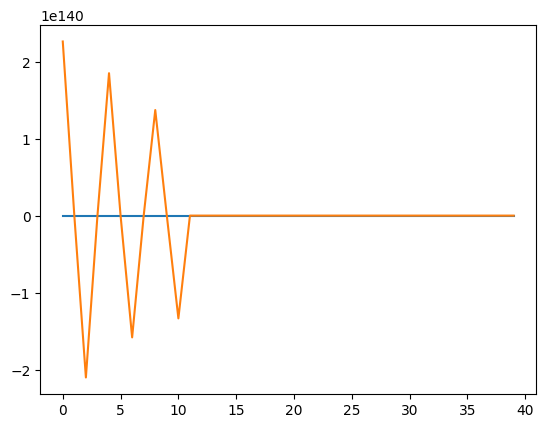

In [78]:
print(len(h_p))
plt.plot(h_p[10])
#plt.plot(h_p[-1])
plt.plot(h_p[-1])




In [45]:
# obtain the ground truth solution via the Cole-Hopf transformation
# we use numerical integration to get the true solution

[Gauss_pts, weights] = onp.polynomial.hermite.hermgauss(80)

def u_true(x1, x2):
    temp = x2-jnp.sqrt(4*nu*x1)*Gauss_pts
    val1 = weights * jnp.sin(jnp.pi*temp) * jnp.exp(-jnp.cos(jnp.pi*temp)/(2*jnp.pi*nu))
    val2 = weights * jnp.exp(-jnp.cos(jnp.pi*temp)/(2*jnp.pi*nu))
    return -jnp.sum(val1)/jnp.sum(val2)



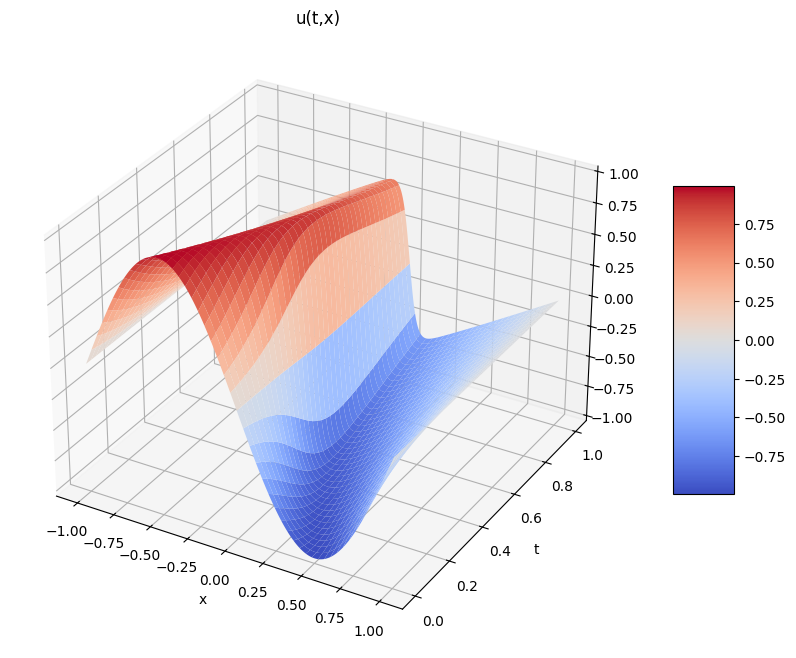

In [4]:
# plot the solution u(x,y), at the space-time domain or at a single time
    
def plot_u(num_pts1, num_pts2):
    xx = onp.linspace(0, 1, num_pts1)
    yy = onp.linspace(-1, 1, num_pts2)
    XX, YY = onp.meshgrid(xx, yy)

    # vectorized (x,y) coordinates
    XXv = onp.array(XX.flatten())
    YYv = onp.array(YY.flatten())

    ZZ_u = vmap(u_true)(XXv, YYv)
    ZZ_u = ZZ_u.reshape(num_pts2,num_pts1)
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    u_surf=ax.plot_surface(YY, XX, ZZ_u, cmap=plt.cm.coolwarm)
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('u(t,x)')
    
    fig.colorbar(u_surf, shrink= 0.5, aspect = 5)
    plt.show()
    
def plot_u_time_t(t, num_pts):
    xx = t
    yy = onp.linspace(-1, 1, num_pts)
    XX, YY = onp.meshgrid(xx, yy)

    # vectorized (x,y) coordinates
    XXv = onp.array(XX.flatten())
    YYv = onp.array(YY.flatten())

    ZZ_u = vmap(u_true)(XXv, YYv)
    
    fig = plt.figure(figsize=(12,8))
    plt.plot(yy, ZZ_u)
    plt.xlabel('x')
    plt.title('u(t,x) at time %f' %t)
    plt.show()
    
# test
# plot the figure
plot_u(40,400)

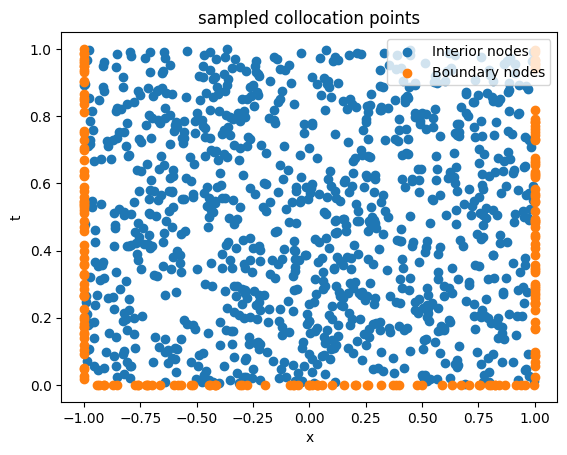

In [6]:
# sampled collocation points

def sample_points(N_domain, N_boundary):
    # interior nodes
    X_domain = random.uniform(0, 1.0, (N_domain, 2))
    X_domain[:,1] = 2*X_domain[:,1]-1
    X_boundary = onp.zeros((N_boundary, 2))

    # generate random boundary points on the faces of the domain 

    # bottom face
    X_boundary[:int(N_boundary/3), 1] = random.uniform(-1.0, 1.0, int(N_boundary/3))
    # right face
    X_boundary[int(N_boundary/3):2*int(N_boundary/3), 0] = random.uniform(0.0, 1.0, int(N_boundary/3))
    X_boundary[int(N_boundary/3):2*int(N_boundary/3), 1] = 1
    # left face
    X_boundary[2*int(N_boundary/3):, 0] = random.uniform(0.0, 1.0, int(N_boundary/3))
    X_boundary[2*int(N_boundary/3):, 1] = -1
    
    return X_domain, X_boundary

N_domain_tot = 1000
N_boundary_tot = 201

X_domain_tot, X_boundary_tot = sample_points(N_domain_tot, N_boundary_tot) # [M 2] [dM 2]

fig, ax = plt.subplots()
ax.scatter(X_domain_tot[range(N_domain_tot), 1], X_domain_tot[range(N_domain_tot), 0], label='Interior nodes')
ax.scatter(X_boundary_tot[range(N_boundary_tot), 1], X_boundary_tot[range(N_boundary_tot), 0], label='Boundary nodes')
ax.legend(loc="upper right")
ax.set_xlabel('x')
ax.set_ylabel('t')
plt.title('sampled collocation points')
plt.show()

Now, let us define kernels / covariance functions that are used to solve the PDEs

We use kernels for both time and space as:
$$k(x,y) = \exp(-\alpha_1^2(x_1-y_1)^2-\alpha_2^2(x_2-y_2)^2)$$

where:
$\alpha_1$: scale parameter in time

$\alpha_2$: scale parameter in space

## 1D time derivative equation 1 Phase

\begin{equation*}
\begin{aligned}
& \partial_t p + \partial_x (K_x(x) \partial_x \Phi_p) = f , x \in [-1,1], t \in [0,1]\\


& \nabla \Phi_p(x,t) = \nabla p_p - \rho_p g \\
& S = \frac{p}{\phi} \\
& f(\{S_p\}_{p=\{o,w,g\}})=0 \\

& \partial_t p + \partial_x (K_x(x) \partial_x p) = f , x \in [-1,1], t \in [0,1]\\

& u(0,x)=-\sin(\pi x)\\
& u(t,-1)=u(t,1)=0
\end{aligned}
\end{equation*}

The parameter $\nu$ controls the shock.

### DOFs

$$t: t_1,t_2$$
$$x: x_1,x_2$$

### Equation

\begin{equation*}
\begin{aligned}
\partial_t p(x,t) - \partial_x (\exp(k(x))  \partial_x p(x,t)) = f \\
\partial_t p(x,t) - ( \exp(k(x)) (\partial_x k(x) \partial_x p(x,t) + \partial_{xx} p(x,t))) = f
\end{aligned}
\end{equation*}


# Operators

## Forward: $p$

\begin{equation*}
\begin{aligned}
L_1: p \\
L_2: \partial_t p \\
L_3: \partial_x p \\
L_4: \partial_{xx} p \\
\end{aligned}
\end{equation*}

## Forward: $k$

\begin{equation*}
\begin{aligned}
\tilde{L}_1: k(x) \\
\tilde{L}_2: \partial_x k(x) \\
\end{aligned}
\end{equation*}

In [7]:

# kernels and derivatives

def kappa(t1, x1, t2, x2, sigma):
    # x,y are 2D input row vectors
    
    scale_t = sigma[0]
    scale_x = sigma[1]
    
    r = (scale_t*(t1-t2))**2+(scale_x*(x1-x2))**2

    return jnp.exp(-r)


def D_t1_kappa(t1, x1, t2, x2, sigma):
    val = grad(kappa,0)(t1, x1, t2, x2, sigma)
    return val

def D_x1_kappa(t1, x1, t2, x2, sigma):
    val = grad(kappa,1)(t1, x1, t2, x2, sigma)
    return val

def DD_x1_kappa(t1, x1, t2, x2, sigma):
    val = grad(grad(kappa,1),1)(t1, x1, t2, x2, sigma)
    return val

def D_t2_kappa(t1, x1, t2, x2, sigma):
    val = grad(kappa,2)(t1, x1, t2, x2, sigma)
    return val

def D_x2_kappa(t1, x1, t2, x2, sigma):
    val = grad(kappa,3)(t1, x1, t2, x2, sigma)
    return val

def DD_x2_kappa(t1, x1, t2, x2, sigma):
    val = grad(grad(kappa,3),3)(t1, x1, t2, x2, sigma)
    return val

def D_t1_D_t2_kappa(t1, x1, t2, x2, sigma):
    val = grad(grad(kappa,0),2)(t1, x1, t2, x2, sigma)
    return val

def D_t1_D_x2_kappa(t1, x1, t2, x2, sigma):
    val = grad(grad(kappa,0),3)(t1, x1, t2, x2, sigma)
    return val

def D_t1_DD_x2_kappa(t1, x1, t2, x2, sigma):
    val = grad(grad(grad(kappa,0),3),3)(t1, x1, t2, x2, sigma)
    return val

def D_x1_D_x2_kappa(t1, x1, t2, x2, sigma):
    val = grad(grad(kappa,1),3)(t1, x1, t2, x2, sigma)
    return val

def D_x1_DD_x2_kappa(t1, x1, t2, x2, sigma):
    val = grad(grad(grad(kappa,1),3),3)(t1, x1, t2, x2, sigma)
    return val

def DD_x1_DD_x2_kappa(t1, x1, t2, x2, sigma):
    val = grad(grad(grad(grad(kappa,1),1),3),3)(t1, x1, t2, x2, sigma)
    return val


Now, we will construct the Gram matrix, based on the observation $u(x_i), u_t(x_i), u_x(x_i), u_{xx}(x_i)$

We organize all the variables in the way: $[v_1,v_2,v_3,v_0,v_b]$, where $v_0, v_1, v_2, v_3$ represent the interior nodal values of $u(x_i), u_t(x_i), u_x(x_i), u_{xx}(x_i)$, respectively; and $v_b$ is the boundary value. 

The Gram matrix $\Theta$ is then determined by this organization. Next code block is to construct this matrix.


In [8]:
onp.tile(onp.array([0,1]),(3,1))

array([[0, 1],
       [0, 1],
       [0, 1]])

In [9]:
# vectorized construction of the Gram matrix Theta
def assembly_Theta(X_domain, X_boundary, nugget, set_sigma):
    
    N_domain = X_domain.shape[0] # [M 2]
    N_boundary = X_boundary.shape[0] # [dM 2]
    Theta_u = jnp.zeros((4*N_domain + N_boundary, 4*N_domain + N_boundary))
    Theta_a = jnp.zeros((2*N_domain, 2*N_domain))

    # auxiliary variables to make things readable
    # interior points coordinates
    Xd0=X_domain[:N_domain, 0]
    Xd1=X_domain[:N_domain, 1]
    
    # interior + boundary points coordinates
    Xdb0=jnp.concatenate([Xd0, X_boundary[:N_boundary, 0]])
    print("interior + boundary points coordinates")
    print(Xdb0.shape)
    Xdb1=jnp.concatenate([Xd1, X_boundary[:N_boundary, 1]])

    # interior v.s. interior interaction (used for construct kernel matrix)
    XXdd0=jnp.transpose(jnp.tile(Xd0,(N_domain,1)))
    print("interior v.s. interior interaction (used for construct kernel matrix)")
    print(XXdd0.shape)
    XXdd1=jnp.transpose(jnp.tile(Xd1,(N_domain,1)))

    # interior+boudary v.s. interior+bpundary interaction
    XXdbdb0=jnp.transpose(jnp.tile(Xdb0,(N_domain+N_boundary,1)))
    XXdbdb1=jnp.transpose(jnp.tile(Xdb1,(N_domain+N_boundary,1)))

    # interior v.s. interior+boundary interaction
    XXddb0=jnp.transpose(jnp.tile(Xd0,(N_domain+N_boundary,1)))
    XXddb1=jnp.transpose(jnp.tile(Xd1,(N_domain+N_boundary,1)))
    XXddb0_2=jnp.tile(Xdb0,(N_domain,1))
    XXddb1_2=jnp.tile(Xdb1,(N_domain,1))

    # Construct kernel matrix
    # interior v.s. interior 
    val = vmap(lambda t1, x1, t2, x2: D_t1_D_t2_kappa(t1, x1, t2, x2, set_sigma))(
        XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten()
    )
    Theta = jop.index_update(Theta, jop.index[0:N_domain, 0:N_domain], jnp.reshape(val, (N_domain, N_domain)))
    
    val = vmap(lambda t1, x1, t2, x2: D_t1_D_x2_kappa(t1, x1, t2, x2, set_sigma))(
        XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten()
    )
    Theta = jop.index_update(Theta, jop.index[0:N_domain, N_domain:2*N_domain], jnp.reshape(val, (N_domain, N_domain)))
    Theta = jop.index_update(Theta, jop.index[N_domain:2*N_domain, 0:N_domain], jnp.transpose(jnp.reshape(val, (N_domain, N_domain))))
    
    val = vmap(lambda t1, x1, t2, x2: D_t1_DD_x2_kappa(t1, x1, t2, x2, set_sigma))(
        XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten()
    )
    Theta = jop.index_update(Theta, jop.index[0:N_domain, 2*N_domain:3*N_domain], jnp.reshape(val, (N_domain, N_domain)))
    Theta = jop.index_update(Theta, jop.index[2*N_domain:3*N_domain, 0:N_domain], jnp.transpose(jnp.reshape(val, (N_domain, N_domain))))
    
    val = vmap(lambda t1, x1, t2, x2: D_x1_D_x2_kappa(t1, x1, t2, x2, set_sigma))(
        XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten()
    )
    Theta = jop.index_update(Theta, jop.index[N_domain:2*N_domain, N_domain:2*N_domain], jnp.reshape(val, (N_domain, N_domain)))
    
    val = vmap(lambda t1, x1, t2, x2: D_x1_DD_x2_kappa(t1, x1, t2, x2, set_sigma))(
        XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten()
    )
    Theta = jop.index_update(Theta, jop.index[N_domain:2*N_domain, 2*N_domain:3*N_domain], jnp.reshape(val, (N_domain, N_domain)))
    Theta = jop.index_update(Theta, jop.index[2*N_domain:3*N_domain, N_domain:2*N_domain], jnp.transpose(jnp.reshape(val, (N_domain, N_domain))))
    
    val = vmap(lambda t1, x1, t2, x2: DD_x1_DD_x2_kappa(t1, x1, t2, x2, set_sigma))(
        XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten()
    )
    Theta = jop.index_update(Theta, jop.index[2*N_domain:3*N_domain, 2*N_domain:3*N_domain], jnp.reshape(val, (N_domain, N_domain)))
    
    # interior+boundary v.s. interior+boundary
    val = vmap(lambda t1, x1, t2, x2: kappa(t1, x1, t2, x2, set_sigma))(
        XXdbdb0.flatten(),XXdbdb1.flatten(),jnp.transpose(XXdbdb0).flatten(),jnp.transpose(XXdbdb1).flatten()
    )
    Theta = jop.index_update(Theta, jop.index[3*N_domain:, 3*N_domain:], jnp.reshape(val, (N_domain+N_boundary, N_domain+N_boundary)))
    
    # interior v.s. interior+boundary
    val = vmap(lambda t1, x1, t2, x2: D_t1_kappa(t1, x1, t2, x2, set_sigma))(
        XXddb0.flatten(),XXddb1.flatten(),XXddb0_2.flatten(),XXddb1_2.flatten()
    )
    Theta = jop.index_update(Theta, jop.index[0:N_domain, 3*N_domain:], jnp.reshape(val, (N_domain, N_domain+N_boundary)))
    Theta = jop.index_update(Theta, jop.index[3*N_domain:, 0:N_domain], jnp.transpose(jnp.reshape(val, (N_domain, N_domain+N_boundary))))
    
    val = vmap(lambda t1, x1, t2, x2: D_x1_kappa(t1, x1, t2, x2, set_sigma))(
        XXddb0.flatten(),XXddb1.flatten(),XXddb0_2.flatten(),XXddb1_2.flatten()
    )
    Theta = jop.index_update(Theta, jop.index[N_domain:2*N_domain, 3*N_domain:], jnp.reshape(val, (N_domain, N_domain+N_boundary)))
    Theta = jop.index_update(Theta, jop.index[3*N_domain:, N_domain:2*N_domain], jnp.transpose(onp.reshape(val, (N_domain, N_domain+N_boundary))))
    
    val = vmap(lambda t1, x1, t2, x2: DD_x1_kappa(t1, x1, t2, x2, set_sigma))(
        XXddb0.flatten(),XXddb1.flatten(),XXddb0_2.flatten(),XXddb1_2.flatten()
        )
    Theta = jop.index_update(Theta, jop.index[2*N_domain:3*N_domain, 3*N_domain:], jnp.reshape(val, (N_domain, N_domain+N_boundary)))
    Theta = jop.index_update(Theta, jop.index[3*N_domain:, 2*N_domain:3*N_domain], jnp.transpose(jnp.reshape(val, (N_domain, N_domain+N_boundary))))
    
    # calculate trace
    trace1 = jnp.trace(Theta[:N_domain, :N_domain])
    trace2 = jnp.trace(Theta[N_domain:2*N_domain, N_domain:2*N_domain])
    trace3 = jnp.trace(Theta[2*N_domain:3*N_domain, 2*N_domain:3*N_domain])
    trace4 = jnp.trace(Theta[3*N_domain:, 3*N_domain:])
    ratio = [trace1/trace4, trace2/trace4, trace3/trace4]
    
    temp=jnp.concatenate((ratio[0]*jnp.ones((1,N_domain)), ratio[1]*jnp.ones((1,N_domain)), ratio[2]*jnp.ones((1,N_domain)), jnp.ones((1,N_domain+N_boundary))), axis=1)
    Theta = Theta + nugget*jnp.diag(temp[0]) 
    L = jnp.linalg.cholesky(Theta)
    
    return L


In the above, we added trace-adaptive nugget terms to regularize the Gram matrix
\begin{equation*}
\Theta_{\lambda} = \Theta +
\text{nugget}\times\begin{bmatrix}
\lambda_1 I & 0 & 0 & 0\\
0 & \lambda_2 I & 0 & 0\\
0 & 0 & \lambda_3I & 0 \\
0 & 0 & 0 & I
\end{bmatrix}
\end{equation*}
where $\lambda_1, \lambda_2, \lambda_3$ are selected to be the trace ratios of the orginal Gram matrix

Then, we solve the following optimization problem:
\begin{equation*}
\begin{aligned}
\min&\quad   [v_1,v_2,v_3,v_0,v_b]\Theta_{\lambda}^{-1} [v_1,v_2,v_3,v_0,v_b]^T\\
  \text{s.t.}&\quad v_1+\alpha v_0v_2-\nu v_3=f, \text{ and } v_b = \text{boundary data}
\end{aligned}
\end{equation*}

Here, $v_0, v_1, v_2, v_3$ represent the interior nodal values of $u(x_i), u_t(x_i), u_x(x_i), u_{xx}(x_i)$, respectively.

In [10]:
# loss functions
def J(v,rhs_f,bdy_g,L):
    N_domain = rhs_f.shape[0]
    v0 = v[:N_domain]
    v2 = v[N_domain:2*N_domain]
    v3 = v[2*N_domain:]
    
    vv = jnp.append(nu*v3+rhs_f-alpha*v0*v2, v2)
    vv = jnp.append(vv, v3)
    vv = jnp.append(vv, v0)
    vv = jnp.append(vv, bdy_g)
    temp = jnp.linalg.solve(L,vv)
    return jnp.dot(temp, temp)

# gradient of loss functions
grad_J = grad(J)

# Hessian in the Gaussian Newton method
def Hessian_GN(v,rhs_f,bdy_g,L):
    N_domain = rhs_f.shape[0]
    N_boundary = bdy_g.shape[0]
    v0 = v[:N_domain]
    v2 = v[N_domain:2*N_domain]
    v3 = v[2*N_domain:]

    mtx = jnp.zeros((4*N_domain+N_boundary, 3*N_domain))
    mtx1 = jnp.concatenate((-alpha*jnp.diag(v2), -alpha*jnp.diag(v0), nu*jnp.eye(N_domain)), axis=1)
    mtx = jop.index_update(mtx, jop.index[0:N_domain, :], mtx1)
    mtx = jop.index_update(mtx, jop.index[N_domain:2*N_domain, N_domain:2*N_domain], jnp.eye(N_domain))
    mtx = jop.index_update(mtx, jop.index[2*N_domain:3*N_domain, 2*N_domain:3*N_domain], jnp.eye(N_domain))
    mtx = jop.index_update(mtx, jop.index[3*N_domain:4*N_domain, :N_domain], jnp.eye(N_domain))
    ss = jnp.linalg.solve(L, mtx)
    return 2*jnp.matmul(jnp.transpose(ss),ss)

# solve PDEs
def pde_solver(X_domain, X_boundary, nugget, max_iter, initial_sol, set_sigma, output_history = 0):
    N_domain = X_domain.shape[0]
    
    rhs_f = vmap(f)(X_domain[:,0], X_domain[:,1])  # rhs data
    bdy_g = vmap(u)(X_boundary[:,0], X_boundary[:,1]) # boundary data
    
    # define cost function
    L = assembly_Theta(X_domain, X_boundary, nugget, set_sigma)
    sol = initial_sol
    step_size = 1
    
    J_hist = [] # history of loss function values
    J_now = J(sol,rhs_f,bdy_g,L)
    J_hist.append(J_now)
    
    for iter_step in range(max_iter):
        temp = jnp.linalg.solve(Hessian_GN(sol,rhs_f,bdy_g,L), grad_J(sol,rhs_f,bdy_g,L))
        sol = sol - step_size*temp
        
        # iteration history
        if output_history == 1:
            J_now = J(sol,rhs_f,bdy_g,L)
            J_hist.append(J_now)
            print('iter = ', iter_step, 'Gauss-Newton step size =', step_size, ' J = ', J_now)
    J_now = J(sol,rhs_f,bdy_g,L)
    return sol, J_hist, J_now, L




In [11]:
# ----- test pde solution

nugget=1e-5
max_iter=12
initial_sol=random.normal(0, 1.0, (3*N_domain_tot))
set_sigma=jnp.array([3,20])
print('parameter sigma is set to be ', set_sigma)
sol, J_hist, J_final, L = pde_solver(X_domain_tot, X_boundary_tot, nugget, max_iter, initial_sol, set_sigma, 1)



parameter sigma is set to be  [ 3 20]
interior + boundary points coordinates
(1201,)
interior v.s. interior interaction (used for construct kernel matrix)
(1000, 1000)


AttributeError: module 'jax.ops' has no attribute 'index_update'

In [10]:
# extend solution to the whole domain: functions

def construct_inpTheta(X_test, X_domain, X_boundary):
    N_domain = X_domain.shape[0]
    N_boundary = X_boundary.shape[0]
    N_test = X_test.shape[0]
    inpTheta = onp.zeros((N_test, 4*N_domain + N_boundary))

    # auxiliary variables to make things readable
    
    # X_left coordinates
    Xt0=X_test[:,0]
    Xt1=X_test[:,1]
    
    # interior points coordinates
    Xd0=X_domain[:N_domain, 0]
    Xd1=X_domain[:N_domain, 1]
    
    # interior + boundary points coordinates
    Xdb0=onp.concatenate([Xd0, X_boundary[:N_boundary, 0]])
    Xdb1=onp.concatenate([Xd1, X_boundary[:N_boundary, 1]])
    
    # left v.s. interior
    XXtd0=onp.transpose(onp.tile(Xt0,(N_domain,1)))
    XXtd1=onp.transpose(onp.tile(Xt1,(N_domain,1)))
    XXtd0_2=onp.tile(Xd0,(N_test,1))
    XXtd1_2=onp.tile(Xd1,(N_test,1))
    
    # left v.s. interior + boundary
    XXtdb0=onp.transpose(onp.tile(Xt0,(N_domain+N_boundary,1)))
    XXtdb1=onp.transpose(onp.tile(Xt1,(N_domain+N_boundary,1)))
    XXtdb0_2=onp.tile(Xdb0,(N_test,1))
    XXtdb1_2=onp.tile(Xdb1,(N_test,1))
    
    # constructing Theta matrix
    val = vmap(lambda x1, x2, y1, y2: D_y1_kappa(x1, x2, y1, y2, set_sigma))(XXtd0.flatten(),XXtd1.flatten(),XXtd0_2.flatten(),XXtd1_2.flatten())
    inpTheta[:,:N_domain] = onp.reshape(val, (N_test, N_domain))
    
    val = vmap(lambda x1, x2, y1, y2: D_y2_kappa(x1, x2, y1, y2, set_sigma))(XXtd0.flatten(),XXtd1.flatten(),XXtd0_2.flatten(),XXtd1_2.flatten())
    inpTheta[:,N_domain:2*N_domain] = onp.reshape(val, (N_test, N_domain))
    
    val = vmap(lambda x1, x2, y1, y2: DD_y2_kappa(x1, x2, y1, y2, set_sigma))(XXtd0.flatten(),XXtd1.flatten(),XXtd0_2.flatten(),XXtd1_2.flatten())
    inpTheta[:,2*N_domain:3*N_domain] = onp.reshape(val, (N_test, N_domain))
    
    val = vmap(lambda x1, x2, y1, y2: kappa(x1, x2, y1, y2, set_sigma))(XXtdb0.flatten(),XXtdb1.flatten(),XXtdb0_2.flatten(),XXtdb1_2.flatten())
    inpTheta[:,3*N_domain:4*N_domain+N_boundary] = onp.reshape(val, (N_test, N_domain+N_boundary))

    return inpTheta


def extend_solution(X_test, L, v):
        
    inp_Theta = construct_inpTheta(X_test, X_domain_tot, X_boundary_tot)
    
    aux = jnp.linalg.solve(jnp.transpose(L),jnp.linalg.solve(L,v))
    
    extended_u = onp.matmul(inp_Theta,aux)
    return extended_u


def sol_time_t(t, num_pts, sol, L):
    xx=t
    yy = onp.linspace(-1, 1, num_pts)
    XX, YY = onp.meshgrid(xx, yy)

    # vectorized (x,y) coordinates
    XXv = onp.array(XX.flatten())
    YYv = onp.array(YY.flatten())
    XXv=onp.expand_dims(XXv, axis=1) 
    YYv=onp.expand_dims(YYv, axis=1) 

    X_test=jnp.concatenate((XXv,YYv), axis=1)
    
    rhs_f = vmap(f)(X_domain_tot[:,0], X_domain_tot[:,1])  
    bdy_g = vmap(u)(X_boundary_tot[:,0], X_boundary_tot[:,1])
    v0 = sol[:N_domain_tot]
    v2 = sol[N_domain_tot:2*N_domain_tot]
    v3 = sol[2*N_domain_tot:]
    vv = jnp.concatenate((nu*v3+rhs_f-alpha*v0*v2, v2, v3, v0, bdy_g), axis=0)
    
    extended_u = extend_solution(X_test, L, vv)
    u_truth=vmap(u_true)(XXv, YYv)
    u_truth=u_truth.flatten()
    
    # L2err
    L2err = onp.sqrt(onp.sum((extended_u-u_truth)**2)/(num_pts))
    # Maxerr
    Maxerr = onp.max(abs(extended_u-u_truth))
    
    return yy, extended_u, u_truth, L2err, Maxerr

def sol_time_space(num_pts_time, num_pts_space, sol, L):
    xx= onp.linspace(0, 1, num_pts_time)
    yy = onp.linspace(-1, 1, num_pts_space)
    XX, YY = onp.meshgrid(xx, yy)

    # vectorized (x,y) coordinates
    XXv = onp.array(XX.flatten())
    YYv = onp.array(YY.flatten())
    XXv=onp.expand_dims(XXv, axis=1) 
    YYv=onp.expand_dims(YYv, axis=1) 

    X_test=jnp.concatenate((XXv,YYv), axis=1)
    
    rhs_f = vmap(f)(X_domain_tot[:,0], X_domain_tot[:,1])  
    bdy_g = vmap(u)(X_boundary_tot[:,0], X_boundary_tot[:,1])
    v0 = sol[:N_domain_tot]
    v2 = sol[N_domain_tot:2*N_domain_tot]
    v3 = sol[2*N_domain_tot:]
    vv = jnp.concatenate((nu*v3+rhs_f-alpha*v0*v2, v2, v3, v0, bdy_g), axis=0)
    
    extended_u = extend_solution(X_test, L, vv)
    extended_u = extended_u.reshape(num_pts_space, num_pts_time)
    
    u_truth = onp.vectorize(u_true)(XXv, YYv)
    u_truth = u_truth.reshape(num_pts_space, num_pts_time)
    
    # L2err
    L2err = onp.linalg.norm(extended_u-u_truth,'fro')/(onp.sqrt(num_pts_space*num_pts_time))
    
    # Maxerr
    Maxerr = onp.max(abs(extended_u-u_truth))
    
    return XX, YY, extended_u, u_truth, L2err, Maxerr




In [19]:
import numpy as onp
import jax.numpy as jnp
xx = onp.linspace(0,1,5)
yy = onp.linspace(-1,1,5)
XX,YY = onp.meshgrid(xx,yy)
XXv = onp.expand_dims(XX.flatten(),axis=1)
jnp.concatenate((XXv,XXv),axis=1)


Array([[0.  , 0.  ],
       [0.25, 0.25],
       [0.5 , 0.5 ],
       [0.75, 0.75],
       [1.  , 1.  ],
       [0.  , 0.  ],
       [0.25, 0.25],
       [0.5 , 0.5 ],
       [0.75, 0.75],
       [1.  , 1.  ],
       [0.  , 0.  ],
       [0.25, 0.25],
       [0.5 , 0.5 ],
       [0.75, 0.75],
       [1.  , 1.  ],
       [0.  , 0.  ],
       [0.25, 0.25],
       [0.5 , 0.5 ],
       [0.75, 0.75],
       [1.  , 1.  ],
       [0.  , 0.  ],
       [0.25, 0.25],
       [0.5 , 0.5 ],
       [0.75, 0.75],
       [1.  , 1.  ]], dtype=float64)

In [11]:
# extend solution: data calculation

num_pts_time = 30
num_pts_space = 100
XX, YY, extended_u, u_truth, space_time_L2err, space_time_Maxerr = sol_time_space(num_pts_time, num_pts_space, sol, L)

t = 0.2
yy, extended_u_t1, u_truth_t1, L2err_t1, Maxerr_t1 = sol_time_t(t, num_pts_space, sol, L)

t = 0.5
yy, extended_u_t2, u_truth_t2, L2err_t2, Maxerr_t2 = sol_time_t(t, num_pts_space, sol, L)

t = 0.8
yy, extended_u_t3, u_truth_t3, L2err_t3, Maxerr_t3 = sol_time_t(t, num_pts_space, sol, L)



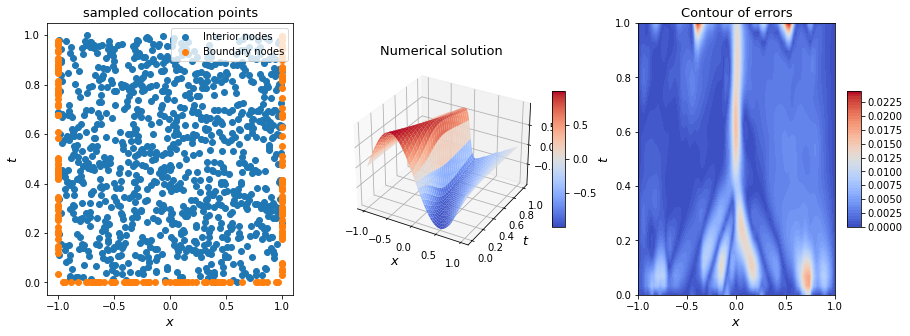

sigma = [ 3 20] , nugget = 1e-05 , # pts:  1201 
 space-time L2 error:  0.0040087824448355285 , max err:  0.024074289330561882


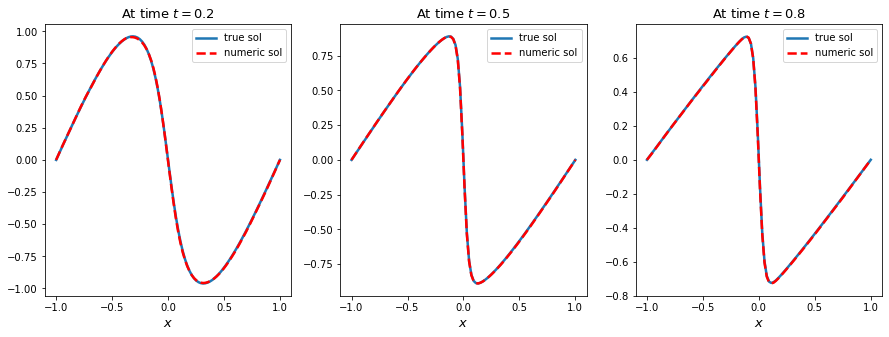

t=0.2, L2 error:  0.004801480892267066 , max err:  0.013451479646311215
t=0.5, L2 error:  0.002995350161981991 , max err:  0.013320106812474336
t=0.8, L2 error:  0.0031517074456226656 , max err:  0.01358028950510276


In [12]:
# plot figures
here_fontsize=13

# --------------space time plot---------------------
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(131)
ax.scatter(X_domain_tot[range(N_domain_tot), 1], X_domain_tot[range(N_domain_tot), 0], label='Interior nodes')
ax.scatter(X_boundary_tot[range(N_boundary_tot), 1], X_boundary_tot[range(N_boundary_tot), 0], label='Boundary nodes')
ax.legend(loc="upper right")
plt.title('sampled collocation points', fontsize=here_fontsize)
plt.xlabel('$x$', fontsize=here_fontsize)
plt.ylabel('$t$', fontsize=here_fontsize) 

# plot the numerical solution
ax = fig.add_subplot(132, projection='3d')
u_sol_surf=ax.plot_surface(YY, XX, extended_u, cmap=plt.cm.coolwarm)
plt.xlabel('$x$', fontsize=here_fontsize)
plt.ylabel('$t$', fontsize=here_fontsize) 
plt.title('Numerical solution', fontsize=here_fontsize)
fig.colorbar(u_sol_surf, shrink= 0.5, aspect = 10)

# contourf
ax = fig.add_subplot(133)
u_contourf=ax.contourf(YY, XX, abs(extended_u-u_truth), 50, cmap=plt.cm.coolwarm)
plt.xlabel('$x$', fontsize=here_fontsize)
plt.ylabel('$t$', fontsize=here_fontsize)
plt.title('Contour of errors', fontsize=here_fontsize)
fig.colorbar(u_contourf, shrink= 0.5, aspect = 10)

plt.show()
fig.tight_layout()

# fig.savefig('Burgers_pts1500_sol_contour_plt.pdf', bbox_inches='tight',dpi=100,pad_inches=0.1)

print('sigma =', set_sigma, ', nugget =', nugget, ', # pts: ', N_domain_tot+N_boundary_tot, '\n space-time L2 error: ', space_time_L2err, ', max err: ', space_time_Maxerr)

# ---------------time slice plot--------------------
fig = plt.figure(figsize=(15,5))

# plot the numerical solution
ax = fig.add_subplot(131)
ax.plot(yy, u_truth_t1, linewidth=2.5, label='true sol')
ax.plot(yy, extended_u_t1, linestyle='dashed', linewidth=2.5, color='red', label='numeric sol')
ax.set_xlabel('$x$', fontsize=here_fontsize)
ax.legend()
plt.title('At time $t = 0.2$', fontsize=here_fontsize)

ax = fig.add_subplot(132)
ax.plot(yy, u_truth_t2, linewidth=2.5, label='true sol')
ax.plot(yy, extended_u_t2, linestyle='dashed', linewidth=2.5, color='red', label='numeric sol')
ax.set_xlabel('$x$', fontsize=here_fontsize)
ax.legend()
plt.title('At time $t = 0.5$', fontsize=here_fontsize)

ax = fig.add_subplot(133)
ax.plot(yy, u_truth_t3, linewidth=2.5, label='true sol')
ax.plot(yy, extended_u_t3, linestyle='dashed', linewidth=2.5, color='red', label='numeric sol')
ax.set_xlabel('$x$', fontsize=here_fontsize)
ax.legend()
plt.title('At time $t = 0.8$',fontsize=here_fontsize)

plt.show()
fig.tight_layout()
# fig.savefig('Burgers_pts1500_time_sol_plt.pdf', bbox_inches='tight',dpi=100,pad_inches=0.1)

print('t=0.2, L2 error: ', L2err_t1 , ', max err: ', Maxerr_t1)
print('t=0.5, L2 error: ', L2err_t2 , ', max err: ', Maxerr_t2)
print('t=0.8, L2 error: ', L2err_t3 , ', max err: ', Maxerr_t3)

